In [2]:
from dsfunctions import forward_pass, forward_pass_nsteps, sample_windspeed, sample_winddirection, sample_geometry
from dsfunctions import plot_matrix, plot_matrix_ensemble, align_geoms, interpolate_geom, get_observation, plot_geometry
from dsfunctions import geom_to_vector

import farsiteutils_v2 as futils
import datetime
import uuid

import numpy as np
from matplotlib import pyplot as plt

from shapely.geometry import Polygon
import pandas as pd
import geopandas as gpd

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.11/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Generate observations

In [3]:
a = 1
b = 1.5
nphi = 20
n_vertex = nphi
phi = np.linspace(0,2*np.pi, nphi, endpoint=False)
nsteps = 100
step_size = 0.01

numberOfObservations = 5
observations = []
for i in range(numberOfObservations):
    x = (a*np.cos(phi))*(1.5**i)
    y = (b+i)*np.sin(phi)+i
    observations.append((x,y))

## Test Northward (180-deg wind)



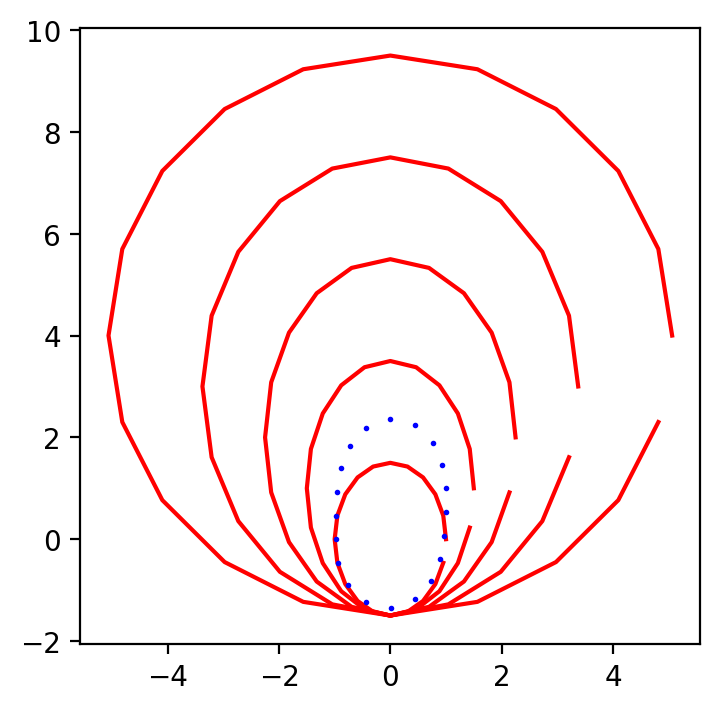

In [4]:
# wdlst = [90/180*np.pi]*200
wdlst = [90*np.pi/180]*100 + [90*np.pi/180]*100
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

x,y = observations[0]
xfin, yfin = forward_pass_nsteps(x, y, wdlst, step_size, nsteps)
for i in range(numberOfObservations):
    x,y = observations[i]
    ax.plot(x,y, 'r-')
ax.plot(xfin, yfin, 'b.', ms=2)

In [5]:
def align_states(state_lst, vertex_count=None):
    if vertex_count is None:
        vertex_count = len(state_lst[0])//2
    x0 = state_lst[0][::2]
    y0 = state_lst[0][1::2]
    x1 = state_lst[1][::2]
    y1 = state_lst[1][1::2]

    geom0 = Polygon(zip(x0,y0))
    geom1 = Polygon(zip(x1,y1))

    geom0, geom1 = align_geoms([geom0, geom1], vertex_count)
    x,y = geom0.exterior.coords.xy
    x0 = x.tolist()[:-1]
    y0 = y.tolist()[:-1]
    state0 = xy_to_state(x0, y0)
    
    x,y = geom1.exterior.coords.xy
    x1 = x.tolist()[:-1]
    y1 = y.tolist()[:-1]
    state1 = xy_to_state(x1, y1)

    return [state0, state1]
    
def xy_to_state(x, y):
    ret = []
    for i in range(len(x)):
        ret.append(x[i])
        ret.append(y[i])

    return np.array(ret).reshape((2*len(x),1))

def state_to_xy(state):
    return state[::2], state[1::2]

def sample_xy(x,y, rng):
    xs = rng.normal(x, scale=100)
    ys = rng.normal(y, scale=100)

    return xs,ys

## Calculated adjusted state

In [6]:
def adjusted_state_EnKF(initial_state, observation_state, 
                        X, n_states, n_samples, rng, 
                        sampled_wslst, sampled_wdlst,
                        step_size=0.01, nsteps=200):

    xkhat_ensemble = np.zeros((n_states, n_samples))
    wk_ensemble = np.zeros((n_states, n_samples))
    vk_ensemble = np.zeros((n_output, n_samples))
    
    zkphat_ensemble = np.zeros((n_states, n_samples))
    xkphat_ensemble = np.zeros((n_states, n_samples))
    ykhat_ensemble = np.zeros((n_output, n_samples))
    
    Xs = np.linalg.cholesky(X)
    # For each sample
    for s in tqdm(range(n_samples)):
    
        xkhat_ensemble[:,s:(s+1)] = initial_state + np.matmul(Xs, rng.normal(size=(n_states,1)))
    
        ws = sampled_wslst[s]
        wd = sampled_wdlst[s]
    
        x,y = state_to_xy(xkhat_ensemble[:, s:(s+1)])
        x1, y1 = forward_pass_nsteps(x, y, [wd]*nsteps, step_size*ws, nsteps)
        forward_state = xy_to_state(x1,y1)
        aligned_states = align_states([initial_state, forward_state])
        
        zkphat_ensemble[:,s:(s+1)] = aligned_states[1]
        ykhat_ensemble[:,s:(s+1)] = xy_to_state(*sample_xy(observation_state[::2],observation_state[1::2],rng))
    
    zkphat_mean = zkphat_ensemble.mean(axis=1, keepdims=True)
    ykhat_mean = ykhat_ensemble.mean(axis=1, keepdims=True)
    
    # Calculate errors
    # zkphat_ensemble -= zkphat_mean
    # ykhat_ensemble -= ykhat_mean
    ezkphat_ensemble = np.zeros_like(zkphat_ensemble)
    for n in range(n_states):
        ezkphat_ensemble[n:(n+1),:] = zkphat_ensemble[n:(n+1),:] - zkphat_mean[n]
    
    eykhat_ensemble = np.zeros_like(ykhat_ensemble)
    for n in range(n_output):
        eykhat_ensemble[n:(n+1),:] = ykhat_ensemble[n:(n+1),:] - ykhat_mean[n]
    
    Pzy = 1/n_samples*np.matmul(ezkphat_ensemble, eykhat_ensemble.T)
    
    Py = 1/n_samples*np.matmul(eykhat_ensemble, eykhat_ensemble.T)
    Pyinv = np.linalg.pinv(Py)
    assert(np.allclose(np.matmul(Py, Pyinv), np.eye(n_output))), 'Inverse calculation is incorrect'
    # warnings.warn('Not checking the inverse calculation')
    
    # Compute estimated Kalman gain based on correlations
    L_EnKF = np.matmul(Pzy, Pyinv)
    
    # compute mean valued state adjustment using measurement y(k)
    # yk = geom_to_state(observation['geometry'], n_states, nvertex)
    yk = observation_state
    adjusted_state = zkphat_mean + np.matmul(L_EnKF, yk - ykhat_mean)
    
    # Compute the state adjustment ensembles to update state covariance matrix X
    for j in range(n_samples):
        xkphat_ensemble[:,j:(j+1)] = zkphat_ensemble[:,j:(j+1)] + np.matmul(L_EnKF, yk - ykhat_ensemble[:,j:(j+1)])
    
    # xkphat_ensemble -= xkphat_ensemble.mean(axis=1, keepdims=True)
    xkphat_mean = xkphat_ensemble.mean(axis=1, keepdims=True)
    exkphat_ensemble = np.zeros_like(xkphat_ensemble)
    for n in range(n_states):
        exkphat_ensemble[n:(n+1), :] = xkphat_ensemble[n:(n+1),:] - xkphat_mean[n]
    
    X = 1/n_samples*np.matmul(exkphat_ensemble, exkphat_ensemble.T) + 1e-10*np.eye(n_states)
    
    return adjusted_state, X, zkphat_ensemble, xkhat_ensemble, ykhat_ensemble


In [7]:
def calculate_rms_state(state1, state2):
    return ((state1 - state2)**2).mean()
def calculate_area_diff_state(state1, state2):
    geom1 = Polygon(zip(state1[::2], state1[1::2]))
    geom2 = Polygon(zip(state2[::2], state2[1::2]))
    
    return (geom1.union(geom2) - geom1.intersection(geom2)).area

In [8]:
def adjusted_state_EnKF_farsite(initial_state, observation_state, 
                        X, n_states, n_samples, rng, 
                        sampled_wslst, sampled_wdlst, dt):

    xkhat_ensemble = np.zeros((n_states, n_samples))
    wk_ensemble = np.zeros((n_states, n_samples))
    vk_ensemble = np.zeros((n_output, n_samples))
    
    zkphat_ensemble = np.zeros((n_states, n_samples))
    xkphat_ensemble = np.zeros((n_states, n_samples))
    ykhat_ensemble = np.zeros((n_output, n_samples))
    
    Xs = np.linalg.cholesky(X)
    # For each sample
    for s in tqdm(range(n_samples)):
    
        xkhat_ensemble[:,s:(s+1)] = initial_state + np.matmul(Xs, rng.normal(size=(n_states,1)))
    
        ws = sampled_wslst[s]
        wd = sampled_wdlst[s]

########################################
        forward_geom = forward_pass_farsite(Polygon(zip(initial_state[::2], initial_state[1::2])),
                                            {'windspeed': int(ws),
                                             'winddirection': int(wd),
                                             'dt': dt})
        if forward_geom is None:
            zero_samples.append(s)
            continue
            
        forward_state = geom_to_vector(forward_geom)
        aligned_states = align_states([initial_state, forward_state], vertex_count = n_vertex)
        
        zkphat_ensemble[:,s:(s+1)] = aligned_states[1]
########################################
        ykhat_ensemble[:,s:(s+1)] = xy_to_state(*sample_xy(observation_state[::2],observation_state[1::2],rng))
    
    zkphat_mean = zkphat_ensemble.mean(axis=1, keepdims=True)
    ykhat_mean = ykhat_ensemble.mean(axis=1, keepdims=True)
    
    # Calculate errors
    # zkphat_ensemble -= zkphat_mean
    # ykhat_ensemble -= ykhat_mean
    ezkphat_ensemble = np.zeros_like(zkphat_ensemble)
    for n in range(n_states):
        ezkphat_ensemble[n:(n+1),:] = zkphat_ensemble[n:(n+1),:] - zkphat_mean[n]
    
    eykhat_ensemble = np.zeros_like(ykhat_ensemble)
    for n in range(n_output):
        eykhat_ensemble[n:(n+1),:] = ykhat_ensemble[n:(n+1),:] - ykhat_mean[n]
    
    Pzy = 1/n_samples*np.matmul(ezkphat_ensemble, eykhat_ensemble.T)
    
    Py = 1/n_samples*np.matmul(eykhat_ensemble, eykhat_ensemble.T)
    Pyinv = np.linalg.pinv(Py)

    inv_product = np.matmul(Py, Pyinv)
    if not np.allclose(inv_product, np.eye(n_output)):
        print('Inverse calculation is incorrect')
        display(inv_product)
        
    # warnings.warn('Not checking the inverse calculation')
    
    # Compute estimated Kalman gain based on correlations
    L_EnKF = np.matmul(Pzy, Pyinv)
    
    # compute mean valued state adjustment using measurement y(k)
    # yk = geom_to_state(observation['geometry'], n_states, nvertex)
    yk = observation_state
    adjusted_state = zkphat_mean + np.matmul(L_EnKF, yk - ykhat_mean)
    
    # Compute the state adjustment ensembles to update state covariance matrix X
    for j in range(n_samples):
        xkphat_ensemble[:,j:(j+1)] = zkphat_ensemble[:,j:(j+1)] + np.matmul(L_EnKF, yk - ykhat_ensemble[:,j:(j+1)])
    
    # xkphat_ensemble -= xkphat_ensemble.mean(axis=1, keepdims=True)
    xkphat_mean = xkphat_ensemble.mean(axis=1, keepdims=True)
    exkphat_ensemble = np.zeros_like(xkphat_ensemble)
    for n in range(n_states):
        exkphat_ensemble[n:(n+1), :] = xkphat_ensemble[n:(n+1),:] - xkphat_mean[n]
    
    X = 1/n_samples*np.matmul(exkphat_ensemble, exkphat_ensemble.T) + 1e-10*np.eye(n_states)
    
    return adjusted_state, X, zkphat_ensemble, xkhat_ensemble, ykhat_ensemble


## Workflow for Data Assimilation

In [9]:
%%time

# Input of data assimilation
n_states = 2*n_vertex
n_output = n_states
n_samples = 100
wssigma = 1
wdsigma = 45
X = 100*np.eye(n_states)  # Initial covariance matrix
rng = np.random.Generator(np.random.PCG64(1234))

sampled_wslst = []
sampled_wdlst = []
for s in range(n_samples):
    sampled_wslst.append(sample_windspeed(1,wssigma,rng))
    sampled_wdlst.append(sample_winddirection(90, wdsigma, rng)/180*np.pi)



# adjusted_simulations
all_adjusted_states_lst = []
all_simulated_states_lst = []

# Prediction for tix=1
# Using the first observation, simulate to the next timepoint
initial_state = xy_to_state(*observations[0])
print('Setting up the first timepoint (ignition)')
all_adjusted_states_lst.append(initial_state)
all_simulated_states_lst.append(initial_state)
# For each sample of the wd and ws, run a simulation and take average as the final

print('Calculating the first prediction tix=1')
zkphat_ensemble = np.zeros((n_states, n_samples))
for s in tqdm(range(n_samples)):
    wd = sampled_wdlst[s]
    ws = sampled_wslst[s]
    
    x1, y1 = forward_pass_nsteps(initial_state[::2], initial_state[1::2], [wd]*nsteps, step_size*ws, nsteps)
    forward_state = xy_to_state(x1,y1)
    aligned_states = align_states([initial_state, forward_state])
    
    zkphat_ensemble[:,s:(s+1)] = aligned_states[1]

zkphat_mean = zkphat_ensemble.mean(axis=1, keepdims=True)
all_adjusted_states_lst.append(zkphat_mean)
all_simulated_states_lst.append(zkphat_mean)

print('Starting calculating of data assimilation')
### EnKF adjustments ###
Xlst = [X]

for tix in range(1,len(observations)):
    print(f'Calculating {tix}/{len(observations)}')
    # Using the forward simulation ensemble average as the initial_state for the next timepoint
    # Note that, we are now at tix=1, and predict for tix=2
    initial_state = all_adjusted_states_lst[-1]
    observation_state = xy_to_state(*observations[tix])
    
    adjusted_state, X, zkphat_ensemble, xkhat_ensemble, ykhat_ensemble = adjusted_state_EnKF(initial_state, observation_state, X, n_states, n_samples, rng, sampled_wslst, sampled_wdlst)
    Xlst.append(X)
    all_adjusted_states_lst.append(adjusted_state)

    initial_state = all_simulated_states_lst[-1]
    ## Calculating without any adjustments
    zkphat_ensemble = np.zeros((n_states, n_samples))
    for s in tqdm(range(n_samples)):
        wd = sampled_wdlst[s]
        ws = sampled_wslst[s]
        
        x1, y1 = forward_pass_nsteps(initial_state[::2], initial_state[1::2], [wd]*nsteps, step_size*ws, nsteps)
        forward_state = xy_to_state(x1,y1)
        aligned_states = align_states([initial_state, forward_state])
        
        zkphat_ensemble[:,s:(s+1)] = aligned_states[1]
    all_simulated_states_lst.append(zkphat_ensemble.mean(axis=1, keepdims=True))

Setting up the first timepoint (ignition)
Calculating the first prediction tix=1


100%|██████████| 100/100 [00:10<00:00,  9.54it/s]


Starting calculating of data assimilation
Calculating 1/5


100%|██████████| 100/100 [00:10<00:00,  9.53it/s]


Calculating 2/5


100%|██████████| 100/100 [00:11<00:00,  9.07it/s]


Calculating 3/5


100%|██████████| 100/100 [00:10<00:00,  9.58it/s]


Calculating 4/5


100%|██████████| 100/100 [00:10<00:00,  9.13it/s]

CPU times: user 2min 14s, sys: 442 ms, total: 2min 14s
Wall time: 2min 16s


## Plot observations and calculations

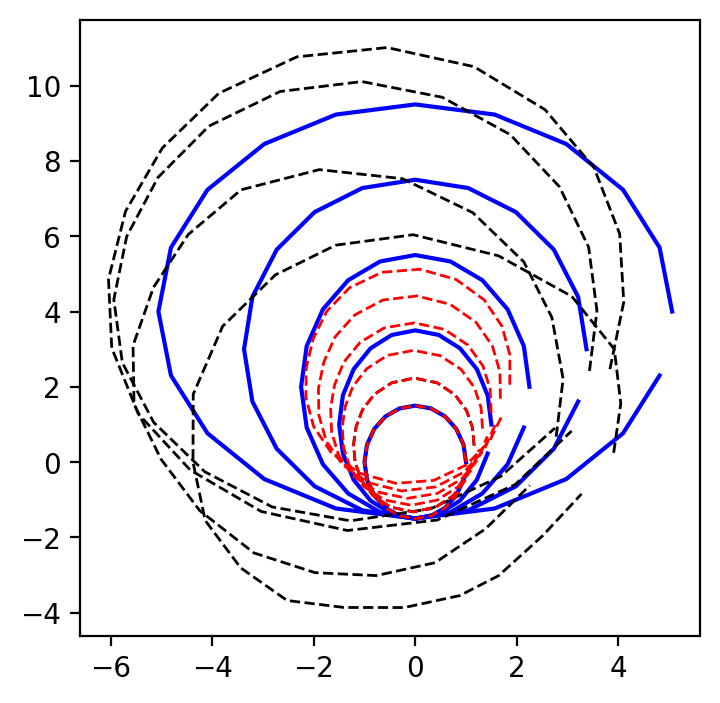

In [10]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

for observation in observations:
    ax.plot(*observation, color=(0,0,1))

for state in all_adjusted_states_lst:
    ax.plot(state[::2], state[1::2], color=(0,0,0), lw=1, ls='--')

for state in all_simulated_states_lst:
    ax.plot(state[::2], state[1::2], color=(1,0,0), lw=1, ls='--')
    
# ax.set_aspect('equal')

Text(0, 0.5, 'RMS error')

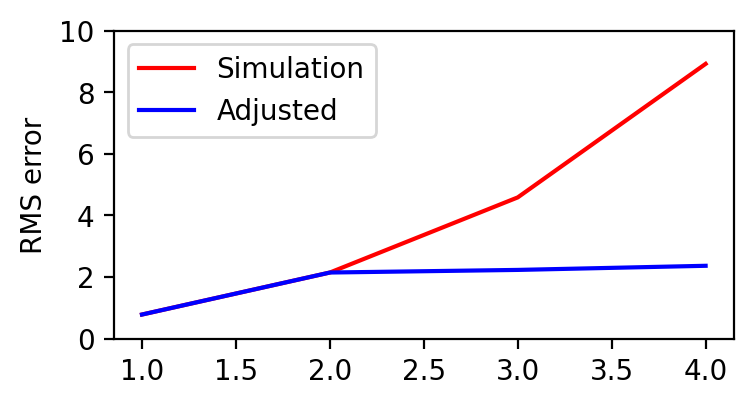

In [11]:
rms_errors_simulated = []
rms_errors_adjusted = []
area_errors_simulated = []
area_errors_adjusted = []
for tix in range(len(observations[:-1])):
    compare_state = xy_to_state(*observations[tix+1])
    simulated_state = all_simulated_states_lst[tix]
    adjusted_state = all_adjusted_states_lst[tix]

    sim_state_aligned, cmp_state_aligned_sim = align_states([simulated_state, compare_state], vertex_count=1000)
    adj_state_aligned, cmp_state_aligned_adj = align_states([adjusted_state, compare_state], vertex_count=1000)
   
    rms_errors_simulated.append(calculate_rms_state(sim_state_aligned, cmp_state_aligned_sim))
    rms_errors_adjusted.append(calculate_rms_state(adj_state_aligned, cmp_state_aligned_adj))
    area_errors_simulated.append(calculate_area_diff_state(sim_state_aligned, cmp_state_aligned_sim))
    area_errors_adjusted.append(calculate_area_diff_state(adj_state_aligned, cmp_state_aligned_adj))

fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)

ax.plot(range(1,len(observations)), rms_errors_simulated, 'r-', label='Simulation')
ax.plot(range(1,len(observations)), rms_errors_adjusted, 'b-', label='Adjusted')
ax.legend()
ax.set_ylim(0,10)
ax.set_ylabel('RMS error')

## Interpolated observations

In [12]:
# Interpolate between observations
ndivide = 10

observations_interp = [observations[0]]
for oix in range(1,len(observations)):
    x0,y0 = observations[oix-1]
    x1,y1 = observations[oix]

    xlst_observation = np.linspace(x0, x1, 10, endpoint=False)
    ylst_observation = np.linspace(y0, y1, 10, endpoint=False)

    for x,y in zip(xlst_observation, ylst_observation):
        observations_interp.append((x,y))    

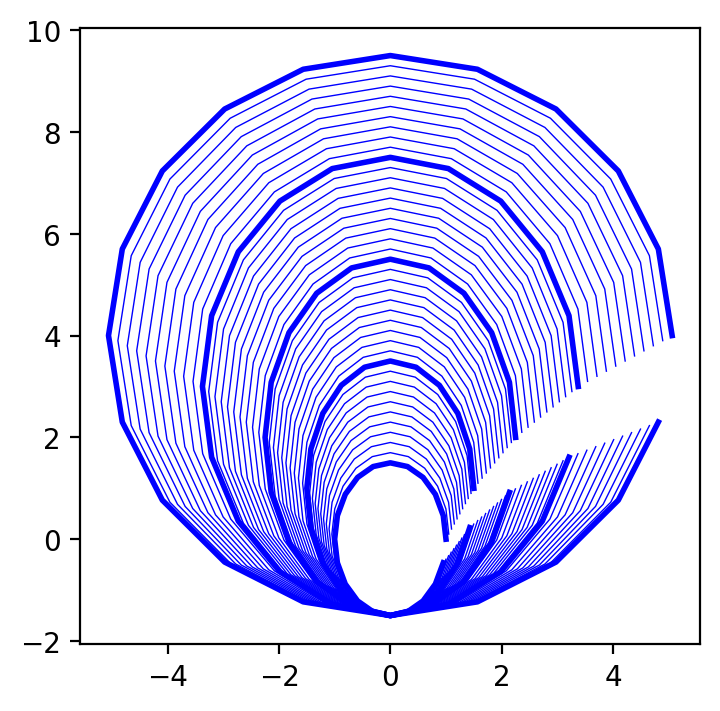

In [13]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
for observation in observations:
    ax.plot(*observation, color=(0,0,1), lw=2)

for observation in observations_interp:
    ax.plot(*observation, color=(0,0,1), lw=0.5)

## Adjusted state with interpolation between observations

In [85]:
%%time

# Input of data assimilation
n_states = 2*n_vertex
n_output = n_states
n_samples = 100
wssigma = 1
wdsigma = 45
X = 100*np.eye(n_states)  # Initial covariance matrix
rng = np.random.Generator(np.random.PCG64(1234))

sampled_wslst = []
sampled_wdlst = []
for s in range(n_samples):
    sampled_wslst.append(sample_windspeed(1,wssigma,rng))
    sampled_wdlst.append(sample_winddirection(90, wdsigma, rng)/180*np.pi)


# adjusted_simulations
all_adjusted_states_interp_lst = []
all_simulated_states_interp_lst = []

# Default values
step_size = 0.01
nsteps = 100//ndivide

# Prediction for tix=1
# Using the first observation, simulate to the next timepoint
initial_state = xy_to_state(*observations_interp[0])
print('Setting up the first timepoint (ignition)')
all_adjusted_states_interp_lst.append(initial_state)
all_simulated_states_interp_lst.append(initial_state)
# For each sample of the wd and ws, run a simulation and take average as the final

print('Calculating the first prediction tix=1')
zkphat_ensemble = np.zeros((n_states, n_samples))
for s in tqdm(range(n_samples)):
    wd = sampled_wdlst[s]
    ws = sampled_wslst[s]
    
    x1, y1 = forward_pass_nsteps(initial_state[::2], initial_state[1::2], [wd]*nsteps, step_size*ws, nsteps)
    forward_state = xy_to_state(x1,y1)
    aligned_states = align_states([initial_state, forward_state])
    
    zkphat_ensemble[:,s:(s+1)] = aligned_states[1]

zkphat_mean = zkphat_ensemble.mean(axis=1, keepdims=True)
all_adjusted_states_interp_lst.append(zkphat_mean)
all_simulated_states_interp_lst.append(zkphat_mean)

print('Starting calculating of data assimilation')
### EnKF adjustments ###
Xlst = [X]

for tix in range(1,len(observations_interp)):
    print(f'Calculating {tix}/{len(observations_interp)}')
    # Using the forward simulation ensemble average as the initial_state for the next timepoint
    # Note that, we are now at tix=1, and predict for tix=2
    initial_state = all_adjusted_states_interp_lst[-1]
    observation_state = xy_to_state(*observations_interp[tix])
    
    adjusted_state, X, zkphat_ensemble, xkhat_ensemble, ykhat_ensemble = adjusted_state_EnKF(initial_state, observation_state, X, n_states, n_samples, rng, sampled_wslst, sampled_wdlst, nsteps=nsteps)
    Xlst.append(X)
    all_adjusted_states_interp_lst.append(adjusted_state)

    initial_state = all_simulated_states_interp_lst[-1]
    ## Calculating without any adjustments
    zkphat_ensemble = np.zeros((n_states, n_samples))
    for s in tqdm(range(n_samples)):
        wd = sampled_wdlst[s]
        ws = sampled_wslst[s]
        
        x1, y1 = forward_pass_nsteps(initial_state[::2], initial_state[1::2], [wd]*nsteps, step_size*ws, nsteps)
        forward_state = xy_to_state(x1,y1)
        aligned_states = align_states([initial_state, forward_state])
        
        zkphat_ensemble[:,s:(s+1)] = aligned_states[1]
    all_simulated_states_interp_lst.append(zkphat_ensemble.mean(axis=1, keepdims=True))

Setting up the first timepoint (ignition)
Calculating the first prediction tix=1


100%|██████████| 100/100 [00:01<00:00, 61.15it/s]


Starting calculating of data assimilation
Calculating 1/41


100%|██████████| 100/100 [00:01<00:00, 72.95it/s]


Calculating 2/41


100%|██████████| 100/100 [00:01<00:00, 62.67it/s]


Calculating 3/41


100%|██████████| 100/100 [00:01<00:00, 72.59it/s]


Calculating 4/41


100%|██████████| 100/100 [00:01<00:00, 70.08it/s]


Calculating 5/41


100%|██████████| 100/100 [00:01<00:00, 70.01it/s]


Calculating 6/41


100%|██████████| 100/100 [00:01<00:00, 74.66it/s]


Calculating 7/41


100%|██████████| 100/100 [00:01<00:00, 62.10it/s]


Calculating 8/41


100%|██████████| 100/100 [00:01<00:00, 58.64it/s]


Calculating 9/41


100%|██████████| 100/100 [00:01<00:00, 67.91it/s]


Calculating 10/41


100%|██████████| 100/100 [00:01<00:00, 68.36it/s]


Calculating 11/41


100%|██████████| 100/100 [00:01<00:00, 65.74it/s]


Calculating 12/41


100%|██████████| 100/100 [00:01<00:00, 74.14it/s]


Calculating 13/41


100%|██████████| 100/100 [00:01<00:00, 66.98it/s]


Calculating 14/41


100%|██████████| 100/100 [00:01<00:00, 69.37it/s]


Calculating 15/41


100%|██████████| 100/100 [00:01<00:00, 62.42it/s]


Calculating 16/41


100%|██████████| 100/100 [00:01<00:00, 63.44it/s]


Calculating 17/41


100%|██████████| 100/100 [00:01<00:00, 62.99it/s]


Calculating 18/41


100%|██████████| 100/100 [00:01<00:00, 63.97it/s]


Calculating 19/41


100%|██████████| 100/100 [00:01<00:00, 65.85it/s]


Calculating 20/41


100%|██████████| 100/100 [00:01<00:00, 68.27it/s]


Calculating 21/41


100%|██████████| 100/100 [00:01<00:00, 68.73it/s]


Calculating 22/41


100%|██████████| 100/100 [00:01<00:00, 65.48it/s]


Calculating 23/41


100%|██████████| 100/100 [00:01<00:00, 69.40it/s]


Calculating 24/41


100%|██████████| 100/100 [00:01<00:00, 64.32it/s]


Calculating 25/41


100%|██████████| 100/100 [00:01<00:00, 63.32it/s]


Calculating 26/41


100%|██████████| 100/100 [00:01<00:00, 66.88it/s]


Calculating 27/41


100%|██████████| 100/100 [00:01<00:00, 64.08it/s]


Calculating 28/41


100%|██████████| 100/100 [00:01<00:00, 63.23it/s]


Calculating 29/41


100%|██████████| 100/100 [00:01<00:00, 62.11it/s]


Calculating 30/41


100%|██████████| 100/100 [00:01<00:00, 64.43it/s]


Calculating 31/41


100%|██████████| 100/100 [00:01<00:00, 71.25it/s]


Calculating 32/41


100%|██████████| 100/100 [00:01<00:00, 71.11it/s]


Calculating 33/41


100%|██████████| 100/100 [00:01<00:00, 71.41it/s]


Calculating 34/41


100%|██████████| 100/100 [00:01<00:00, 69.40it/s]


Calculating 35/41


100%|██████████| 100/100 [00:01<00:00, 68.45it/s]


Calculating 36/41


100%|██████████| 100/100 [00:01<00:00, 63.47it/s]


Calculating 37/41


100%|██████████| 100/100 [00:01<00:00, 72.19it/s]


Calculating 38/41


100%|██████████| 100/100 [00:01<00:00, 68.05it/s]


Calculating 39/41


100%|██████████| 100/100 [00:01<00:00, 61.26it/s]


Calculating 40/41


100%|██████████| 100/100 [00:01<00:00, 65.83it/s]

CPU times: user 2min, sys: 4.83 s, total: 2min 5s
Wall time: 2min 2s


### Plot observations/adjusted calculations

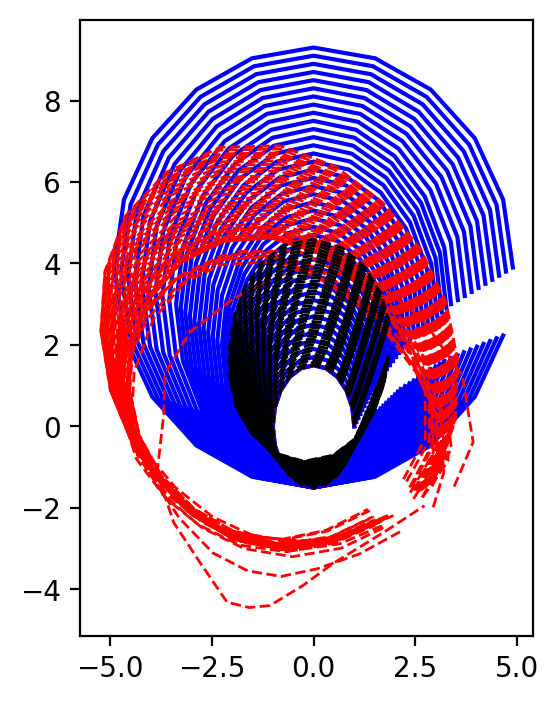

In [86]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

for observation in observations_interp:
    ax.plot(*observation, color=(0,0,1))

for state in all_adjusted_states_interp_lst:
    ax.plot(state[::2], state[1::2], color=(1,0,0), lw=1, ls='--')

for state in all_simulated_states_interp_lst:
    ax.plot(state[::2], state[1::2], color=(0,0,0), lw=1, ls='--')
    
ax.set_aspect('equal')

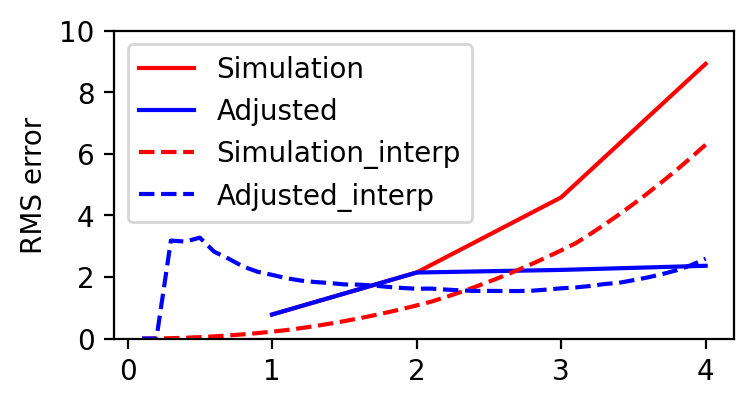

In [87]:
rms_errors_simulated_interp = []
rms_errors_adjusted_interp = []
area_errors_simulated_interp = []
area_errors_adjusted_interp = []
for tix in range(len(observations_interp[:-1])):
    compare_state = xy_to_state(*observations_interp[tix+1])
    simulated_state = all_simulated_states_interp_lst[tix]
    adjusted_state = all_adjusted_states_interp_lst[tix]

    sim_state_aligned, cmp_state_aligned_sim = align_states([simulated_state, compare_state], vertex_count=1000)
    adj_state_aligned, cmp_state_aligned_adj = align_states([adjusted_state, compare_state], vertex_count=1000)
   
    rms_errors_simulated_interp.append(calculate_rms_state(sim_state_aligned, cmp_state_aligned_sim))
    rms_errors_adjusted_interp.append(calculate_rms_state(adj_state_aligned, cmp_state_aligned_adj))
    area_errors_simulated_interp.append(calculate_area_diff_state(sim_state_aligned, cmp_state_aligned_sim))
    area_errors_adjusted_interp.append(calculate_area_diff_state(adj_state_aligned, cmp_state_aligned_adj))

fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)

ax.plot(np.arange(1,len(observations)), rms_errors_simulated, 'r-', label='Simulation')
ax.plot(np.arange(1,len(observations)), rms_errors_adjusted, 'b-', label='Adjusted')
ax.plot(np.arange(1,len(observations_interp))/ndivide, rms_errors_simulated_interp, 'r--', label='Simulation_interp')
ax.plot(np.arange(1,len(observations_interp))/ndivide, rms_errors_adjusted_interp, 'b--', label='Adjusted_interp')
ax.set_ylim(0,10)
ax.set_ylabel('RMS error')
ax.legend()

## Maria Fire

### Forward Maria fire simulations

In [14]:
def calculate(initialidx, 
              observeidx,
              windspeed, winddirection, 
              usr: futils.User,
              lcpidx='43b7f5db36994599861eec4849cc68fd', 
              barrieridx='cb47616cd2dc4ccc8fd523bd3a5064bb'):

    
    # Setup the input data
    inputData = {'description': 'Maria_2019',
                 'igniteidx'  : initialidx,
                 'compareidx' : observeidx,
                 'lcpidx'     : lcpidx,
                 'barrieridx' : barrieridx,

                 'windspeed': windspeed, 'winddirection': winddirection,
                 'relhumid': 90, 'temperature': 20}

    mainapi = usr.calculatePerimeters(inputData)
    mainapi.run_farsite()

def forward_pass_farsite(poly, params):
    '''
        params: take values: 'windspeed', 'winddirection' ,'dt' (dt is a datetime.timedelta object)
    '''
    # Parameters to run the simulation
    windspeed = params['windspeed']
    winddirection = params['winddirection']
    dt = params['dt']
    
    # Create handles for simulation
    fp = futils.FilePaths('/home/jovyan/data/')
    usr = futils.User(fp)

    initialidx = uuid.uuid4().hex
    fpath = f'/home/jovyan/farsite-devAPI/inputs/maria_ignite/Reference/maria_{initialidx}.shp'
    # Creating the shp file for simulation
    gpd.GeoDataFrame({'FID': [0], 'geometry':poly}, crs='EPSG:5070').to_file(fpath)
    
    usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation', 
                                                                                               fpath, datetime.datetime.now(),
                                                                                               'Maria2019']
    
    observeidx = uuid.uuid4().hex
    # Add observationidx only to calculate the dt in the backend
    usr.db.dfObservation.loc[observeidx, 'datetime'] = usr.db.dfObservation.loc[initialidx, 'datetime'] + dt
    
    
    # Run simulation for dt from initialidx
    calculate(initialidx, observeidx, windspeed, winddirection, usr)
    
    # add simulation as the next initial point
    try:
        dfsim = usr.db.dfsimulation[(usr.db.dfsimulation['igniteidx'] == initialidx) & 
                                (usr.db.dfsimulation['compareidx'] == observeidx)]
    except KeyError as e:
        print(e)
        print(usr.db.dfsimulation)
        return None
    
    if len(dfsim) < 1:
        return None
    
    # assert(len(dfsim) == 1) , f'Length of dfsim = {len(dfsim)}'
    if len(dfsim) != 1:
        raise ValueError(f'Length of dfsim = {len(dfsim)}')

    usr.db.dfObservation.loc[dfsim.index[0], ['filetype', 'description']] = ['Observation', 'Maria2019']
    

    simpath = f'/home/jovyan/farsite-devAPI/inputs/maria_ignite/Reference/maria_{observeidx}.shp'
    dfgeom = gpd.read_file(dfsim['filepath'].iloc[0])['geometry']
    assert(len(dfgeom) == 1), f'dfgeom has size = {len(dfgeom)}'
    dfgeom = dfgeom[0]

    # Remove the generated files
    !rm /home/jovyan/farsite-devAPI/inputs/maria_ignite/Reference/*
    
    return Polygon(dfgeom.coords)

## Setup Maria fire observations

In [15]:
wslst = [11, 18, 18, 25, 17, 22, 15, 12, 14, 14, 14]
wdlst = [37, 48, 48, 44, 16, 29, 19, 24, 22, 21, 20]
n_samples = 500
wssigma = 4
wdsigma = 15
rng = np.random.Generator(np.random.PCG64(1234))

maria_observations = []
maria_timestamps = []
sampled_wslst = []
sampled_wdlst = []

for tix in range(10):
    obs, ts = get_observation('Maria2019', tix)
    maria_observations.append(obs)
    maria_timestamps.append(ts)
    sampled_wslst.append([])
    sampled_wdlst.append([])
    for s in range(n_samples):
        sampled_wslst[-1].append(sample_windspeed(wslst[tix],wssigma,rng))
        sampled_wdlst[-1].append(sample_winddirection(wdlst[tix], wdsigma, rng))

## Test

In [16]:
%%time

# Input of data assimilation
n_vertex = 20
n_states = 2*n_vertex
n_output = n_states

X = 1e4*np.eye(n_states)  # Initial covariance matrix

# adjusted_simulations
all_adjusted_states_lst = []
all_simulated_states_lst = []

# Prediction for tix=1
# Using the first observation, simulate to the next timepoint
initial_state = geom_to_vector(maria_observations[0])
dt = maria_timestamps[1] - maria_timestamps[0]
ws_samples = sampled_wslst[0]
wd_samples = sampled_wdlst[0]
print('Setting up the first timepoint (ignition)')
all_adjusted_states_lst.append(initial_state)
all_simulated_states_lst.append(initial_state)
# For each sample of the wd and ws, run a simulation and take average as the final

print('Calculating the first prediction tix=1')
zkphat_ensemble = np.zeros((n_states, n_samples))
zero_samples = []
zkphat_ensemble_lst = []
for s in tqdm(range(n_samples)):
    wd = ws_samples[s]
    ws = wd_samples[s]

    forward_geom = forward_pass_farsite(Polygon(zip(initial_state[::2], initial_state[1::2])),
                                        {'windspeed': int(ws),
                                         'winddirection': int(wd),
                                         'dt': dt})
    if forward_geom is None:
        zero_samples.append(s)
        continue
        
    forward_state = geom_to_vector(forward_geom)
    aligned_states = align_states([initial_state, forward_state], vertex_count = n_vertex)
    
    zkphat_ensemble[:,s:(s+1)] = aligned_states[1]

# Calculate the mean of the non-zero ensembles
zkphat_mean = zkphat_ensemble.sum(axis=1, keepdims=True)/(n_samples - len(zero_samples))

# Fill in the zero samples with the mean
for s in zero_samples:
    zkphat_ensemble[:,s:(s+1)] = zkphat_mean

filled_counts = len(zero_samples)
all_adjusted_states_lst.append(zkphat_mean)
all_simulated_states_lst.append(zkphat_mean)
zkphat_ensemble_lst.append(zkphat_ensemble)

Setting up the first timepoint (ignition)
Calculating the first prediction tix=1


  3%|▎         | 16/500 [00:28<14:01,  1.74s/it]

'igniteidx'
Empty DataFrame
Columns: []
Index: []


 84%|████████▎ | 418/500 [11:42<02:16,  1.66s/it]

'igniteidx'
Empty DataFrame
Columns: []
Index: []


100%|██████████| 500/500 [14:05<00:00,  1.69s/it]

CPU times: user 22.3 s, sys: 6.61 s, total: 28.9 s
Wall time: 14min 5s


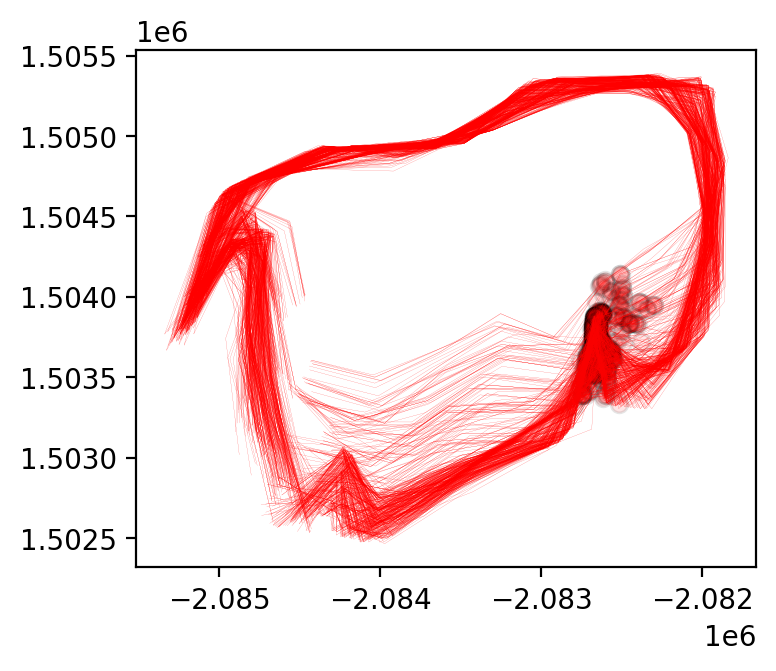

In [17]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_matrix_ensemble(zkphat_ensemble, ax=ax, color=(1,0,0), plot_alix=5, lw=0.05)

In [18]:
print('Starting calculating of data assimilation')
### EnKF adjustments ###
Xlst = [X]

filled_counts = []
for tix in range(1,len(maria_observations[:-1])):
    print(f'Calculating {tix}/{len(maria_observations)-1}')
    # Using the forward simulation ensemble average as the initial_state for the next timepoint
    # Note that, we are now at tix, and predict for tix+1
    initial_state = all_adjusted_states_lst[-1]
    dt = maria_timestamps[tix+1] - maria_timestamps[tix]    
    
    aligned_states = align_states([initial_state, geom_to_vector(maria_observations[tix])], vertex_count=n_vertex)
    observation_state = aligned_states[1]
    
    
    adjusted_state, X, zkphat_ensemble, xkhat_ensemble, ykhat_ensemble = adjusted_state_EnKF_farsite(initial_state, observation_state, X, n_states, n_samples, rng, sampled_wslst[tix], sampled_wdlst[tix], dt)
    Xlst.append(X)
    all_adjusted_states_lst.append(adjusted_state)
    zkphat_ensemble_lst.append(zkphat_ensemble)
    
    initial_state = all_simulated_states_lst[-1]
    ## Calculating without any adjustments
    zkphat_ensemble_sim = np.zeros((n_states, n_samples))
    
    zero_samples = []
    for s in tqdm(range(n_samples)):
        wd = sampled_wdlst[tix][s]
        ws = sampled_wslst[tix][s]

        forward_geom = forward_pass_farsite(Polygon(zip(initial_state[::2], initial_state[1::2])),
                                            {'windspeed': int(ws),
                                             'winddirection': int(wd),
                                             'dt': dt})
        if forward_geom is None:
            zero_samples.append(s)
            continue
            
        forward_state = geom_to_vector(forward_geom)
        aligned_states = align_states([initial_state, forward_state], vertex_count = n_vertex)
        
        zkphat_ensemble_sim[:,s:(s+1)] = aligned_states[1]

    # Calculate the mean of the non-zero ensembles
    zkphat_mean = zkphat_ensemble.sum(axis=1, keepdims=True)/(n_samples - len(zero_samples))
    
    # Fill in the zero samples with the mean
    for s in zero_samples:
        zkphat_ensemble[:,s:(s+1)] = zkphat_mean
        
    filled_counts.append(len(zero_samples))
    all_simulated_states_lst.append(zkphat_ensemble_sim.mean(axis=1, keepdims=True))

Starting calculating of data assimilation
Calculating 1/9


100%|██████████| 500/500 [12:03<00:00,  1.45s/it]


Inverse calculation is incorrect


array([[ 1.00000002e+00, -1.27040995e-08, -2.06114734e-10, ...,
         5.95506242e-09, -1.29746647e-08,  1.77600577e-08],
       [-4.52868935e-10,  1.00000001e+00, -4.84579861e-09, ...,
        -2.01631602e-09, -2.50522700e-09, -8.45322836e-09],
       [ 2.34293526e-09, -1.53407753e-08,  1.00000000e+00, ...,
         5.64507603e-09,  4.68176443e-09,  1.25432584e-08],
       ...,
       [-3.53893303e-09,  1.39074512e-08,  1.51009330e-09, ...,
         9.99999999e-01, -2.32714231e-09, -1.10352183e-08],
       [ 6.92284704e-09, -1.47892053e-08,  1.63195807e-09, ...,
         3.79613864e-09,  1.00000001e+00,  1.17204957e-08],
       [-3.10654147e-09,  1.21684256e-08, -4.91443463e-09, ...,
        -3.44802798e-09, -8.37115587e-09,  9.99999992e-01]])

100%|██████████| 500/500 [12:04<00:00,  1.45s/it]


Calculating 2/9


100%|██████████| 500/500 [09:28<00:00,  1.14s/it]


Inverse calculation is incorrect


array([[ 9.99999998e-01,  3.65875050e-09, -3.19639921e-10, ...,
        -3.36758086e-09,  3.65768137e-09,  4.80077466e-09],
       [ 8.27197790e-10,  9.99999999e-01,  2.35315141e-09, ...,
         1.85502388e-09, -9.51144140e-10, -9.28136136e-10],
       [-1.70192254e-09,  1.92130490e-09,  9.99999996e-01, ...,
        -2.84610219e-09,  1.50374206e-09,  2.11515457e-09],
       ...,
       [ 1.14328843e-09, -1.47251024e-09,  2.96281070e-09, ...,
         1.00000000e+00, -1.24626155e-09, -2.07599979e-09],
       [-2.13309551e-09,  1.41821623e-09, -2.99473541e-09, ...,
        -2.45345703e-09,  1.00000000e+00,  2.41962332e-10],
       [ 1.96214192e-09, -6.16360025e-10,  2.62913795e-09, ...,
         2.02791825e-09, -1.95130997e-09,  9.99999998e-01]])

  0%|          | 1/500 [00:00<01:13,  6.77it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []


  1%|          | 4/500 [00:00<00:32, 15.04it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  1%|          | 6/500 [00:00<00:29, 16.62it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []


  2%|▏         | 8/500 [00:00<00:30, 15.89it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  2%|▏         | 10/500 [00:00<00:29, 16.77it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []


  3%|▎         | 13/500 [00:00<00:26, 18.46it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  3%|▎         | 17/500 [00:01<00:28, 16.78it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  5%|▍         | 23/500 [00:01<00:25, 19.03it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  5%|▌         | 26/500 [00:01<00:26, 17.75it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  6%|▋         | 32/500 [00:01<00:24, 19.37it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  7%|▋         | 36/500 [00:02<00:25, 18.31it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  8%|▊         | 39/500 [00:02<00:26, 17.30it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  8%|▊         | 41/500 [00:02<00:27, 16.83it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  9%|▉         | 45/500 [00:02<00:29, 15.29it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 10%|█         | 50/500 [00:02<00:25, 17.39it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 10%|█         | 52/500 [00:03<00:26, 16.71it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 11%|█         | 56/500 [00:03<00:30, 14.52it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 12%|█▏        | 58/500 [00:03<00:28, 15.33it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 13%|█▎        | 63/500 [00:03<00:25, 16.88it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 14%|█▎        | 68/500 [00:04<00:28, 15.28it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 14%|█▍        | 71/500 [00:04<00:26, 16.20it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 15%|█▌        | 75/500 [00:04<00:25, 16.59it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 16%|█▌        | 79/500 [00:04<00:24, 17.33it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 17%|█▋        | 83/500 [00:04<00:23, 17.83it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 18%|█▊        | 88/500 [00:05<00:21, 19.51it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 19%|█▊        | 93/500 [00:05<00:21, 19.32it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 19%|█▉        | 96/500 [00:05<00:20, 19.57it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 20%|██        | 100/500 [00:05<00:21, 18.89it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 21%|██        | 104/500 [00:06<00:25, 15.65it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 22%|██▏       | 108/500 [00:06<00:22, 17.16it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 22%|██▏       | 112/500 [00:06<00:21, 17.89it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 23%|██▎       | 114/500 [00:06<00:22, 17.33it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 24%|██▎       | 118/500 [00:06<00:22, 16.97it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 24%|██▍       | 122/500 [00:07<00:21, 17.92it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 25%|██▌       | 126/500 [00:07<00:22, 16.55it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 26%|██▌       | 128/500 [00:07<00:22, 16.79it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 27%|██▋       | 133/500 [00:07<00:21, 16.76it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 28%|██▊       | 138/500 [00:08<00:19, 18.19it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 29%|██▊       | 143/500 [00:08<00:19, 18.28it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 29%|██▉       | 147/500 [00:08<00:19, 18.04it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 30%|███       | 151/500 [00:08<00:21, 16.42it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 31%|███       | 153/500 [00:09<00:32, 10.75it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 31%|███▏      | 157/500 [00:09<00:32, 10.70it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 32%|███▏      | 161/500 [00:09<00:26, 13.03it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 33%|███▎      | 165/500 [00:10<00:22, 14.69it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 34%|███▍      | 169/500 [00:10<00:20, 16.44it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 35%|███▍      | 173/500 [00:10<00:19, 17.17it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 35%|███▌      | 177/500 [00:10<00:18, 17.47it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 36%|███▌      | 181/500 [00:10<00:17, 18.40it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 37%|███▋      | 185/500 [00:11<00:19, 16.36it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 38%|███▊      | 190/500 [00:11<00:17, 17.61it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 39%|███▉      | 194/500 [00:11<00:16, 18.08it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 40%|███▉      | 198/500 [00:11<00:16, 18.64it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 41%|████      | 203/500 [00:12<00:16, 18.56it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 41%|████      | 205/500 [00:12<00:15, 18.48it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 42%|████▏     | 209/500 [00:12<00:16, 17.18it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 43%|████▎     | 213/500 [00:12<00:18, 15.88it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 43%|████▎     | 217/500 [00:13<00:16, 16.91it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 44%|████▍     | 222/500 [00:13<00:17, 16.17it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 45%|████▍     | 224/500 [00:13<00:18, 14.72it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 46%|████▌     | 229/500 [00:13<00:16, 16.76it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 47%|████▋     | 233/500 [00:13<00:15, 16.93it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 47%|████▋     | 237/500 [00:14<00:15, 17.23it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 48%|████▊     | 241/500 [00:14<00:16, 15.61it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 49%|████▉     | 245/500 [00:14<00:16, 15.11it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 49%|████▉     | 247/500 [00:14<00:18, 14.01it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 50%|█████     | 252/500 [00:15<00:14, 16.77it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 51%|█████     | 256/500 [00:15<00:14, 17.26it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 52%|█████▏    | 260/500 [00:15<00:16, 14.49it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 52%|█████▏    | 262/500 [00:15<00:15, 15.58it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 53%|█████▎    | 266/500 [00:16<00:15, 14.99it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 54%|█████▍    | 270/500 [00:16<00:14, 15.94it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 55%|█████▌    | 275/500 [00:16<00:16, 13.36it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 56%|█████▌    | 279/500 [00:17<00:14, 15.25it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 57%|█████▋    | 283/500 [00:17<00:13, 16.50it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 57%|█████▋    | 285/500 [00:17<00:14, 14.71it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 57%|█████▋    | 287/500 [00:17<00:15, 13.63it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 58%|█████▊    | 291/500 [00:18<00:31,  6.59it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 59%|█████▉    | 295/500 [00:19<00:25,  8.10it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 59%|█████▉    | 297/500 [00:19<00:21,  9.66it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 60%|██████    | 301/500 [00:19<00:19, 10.06it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 61%|██████    | 305/500 [00:19<00:15, 12.58it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 62%|██████▏   | 309/500 [00:20<00:12, 14.72it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 63%|██████▎   | 313/500 [00:20<00:11, 15.71it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 63%|██████▎   | 317/500 [00:20<00:11, 16.51it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 64%|██████▍   | 321/500 [00:20<00:10, 16.46it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 65%|██████▍   | 323/500 [00:21<00:16, 10.75it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []


 65%|██████▌   | 327/500 [00:21<00:20,  8.49it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 66%|██████▌   | 331/500 [00:22<00:15, 11.09it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 67%|██████▋   | 335/500 [00:22<00:16, 10.07it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 67%|██████▋   | 337/500 [00:22<00:17,  9.24it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 68%|██████▊   | 339/500 [00:22<00:16,  9.59it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 69%|██████▊   | 343/500 [00:23<00:13, 11.91it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 69%|██████▉   | 345/500 [00:23<00:15, 10.21it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 70%|██████▉   | 349/500 [00:23<00:14, 10.55it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 70%|███████   | 351/500 [00:24<00:18,  8.17it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 71%|███████   | 355/500 [00:24<00:17,  8.48it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 72%|███████▏  | 359/500 [00:25<00:12, 11.19it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 73%|███████▎  | 363/500 [00:25<00:10, 13.35it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 73%|███████▎  | 367/500 [00:25<00:08, 15.07it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 74%|███████▍  | 371/500 [00:25<00:08, 15.68it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 75%|███████▌  | 375/500 [00:26<00:08, 14.01it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 76%|███████▌  | 379/500 [00:26<00:10, 11.68it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 76%|███████▌  | 381/500 [00:26<00:11, 10.20it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 77%|███████▋  | 383/500 [00:26<00:10, 10.78it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 77%|███████▋  | 385/500 [00:27<00:12,  9.17it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 78%|███████▊  | 389/500 [00:27<00:12,  9.01it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 79%|███████▊  | 393/500 [00:27<00:09, 10.94it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 79%|███████▉  | 395/500 [00:28<00:08, 12.05it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 79%|███████▉  | 397/500 [00:28<00:12,  8.55it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 80%|███████▉  | 399/500 [00:29<00:16,  6.16it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 81%|████████  | 403/500 [00:29<00:12,  7.63it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 81%|████████▏ | 407/500 [00:29<00:11,  8.36it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 82%|████████▏ | 411/500 [00:30<00:07, 11.34it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 83%|████████▎ | 415/500 [00:30<00:06, 13.42it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 84%|████████▍ | 419/500 [00:30<00:05, 15.11it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 85%|████████▍ | 423/500 [00:30<00:04, 15.42it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 85%|████████▌ | 427/500 [00:31<00:04, 15.59it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 86%|████████▌ | 431/500 [00:31<00:04, 16.04it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 87%|████████▋ | 435/500 [00:31<00:04, 15.58it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 88%|████████▊ | 439/500 [00:31<00:03, 16.16it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 89%|████████▊ | 443/500 [00:32<00:03, 17.14it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 89%|████████▉ | 445/500 [00:32<00:03, 15.96it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 90%|████████▉ | 449/500 [00:32<00:03, 14.68it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 90%|█████████ | 451/500 [00:32<00:03, 14.81it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 91%|█████████ | 455/500 [00:33<00:03, 14.97it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 92%|█████████▏| 459/500 [00:33<00:02, 15.42it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 92%|█████████▏| 461/500 [00:33<00:03, 12.95it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 93%|█████████▎| 463/500 [00:33<00:03, 10.78it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 93%|█████████▎| 465/500 [00:34<00:04,  7.88it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 94%|█████████▍| 469/500 [00:34<00:03,  9.80it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 95%|█████████▍| 473/500 [00:34<00:02, 12.63it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 96%|█████████▌| 478/500 [00:34<00:01, 15.48it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 96%|█████████▋| 482/500 [00:35<00:01, 15.45it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 97%|█████████▋| 484/500 [00:35<00:01, 15.70it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 98%|█████████▊| 488/500 [00:35<00:00, 14.79it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 98%|█████████▊| 492/500 [00:35<00:00, 14.98it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 99%|█████████▉| 496/500 [00:36<00:00, 15.65it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


100%|██████████| 500/500 [00:36<00:00, 13.75it/s]


'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
Calculating 3/9


 56%|█████▌    | 280/500 [16:10<5:35:58, 91.63s/it]

'igniteidx'
Empty DataFrame
Columns: []
Index: []


100%|██████████| 500/500 [24:42<00:00,  2.96s/it]  


Inverse calculation is incorrect


array([[ 9.99999982e-01,  3.93032957e-09,  1.40414142e-08, ...,
        -7.69851093e-10, -1.05903152e-09,  1.16701775e-09],
       [ 7.32062569e-09,  9.99999996e-01, -5.49901887e-09, ...,
        -1.28877509e-11,  9.40567454e-10, -1.07292719e-10],
       [-1.10961370e-08,  5.09660685e-09,  1.00000001e+00, ...,
         1.28318674e-10, -8.78211568e-10,  1.49583954e-09],
       ...,
       [ 7.66011362e-09, -3.21117337e-09, -5.26539714e-09, ...,
         1.00000000e+00,  3.77028564e-10, -9.26756226e-10],
       [-1.07219023e-08,  4.68834096e-09,  6.77426019e-09, ...,
         2.00414937e-10,  1.00000000e+00,  1.49665897e-09],
       [ 7.42364581e-09, -3.53688159e-09, -5.20073475e-09, ...,
        -1.71475201e-10,  8.60451875e-11,  9.99999999e-01]])

  0%|          | 0/500 [00:00<?, ?it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []


  0%|          | 2/500 [00:00<00:32, 15.12it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  1%|          | 4/500 [00:00<00:33, 14.97it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  1%|          | 6/500 [00:00<00:29, 16.53it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  2%|▏         | 8/500 [00:00<00:27, 17.60it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  2%|▏         | 10/500 [00:00<00:26, 18.15it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  2%|▏         | 12/500 [00:00<00:28, 17.14it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  3%|▎         | 14/500 [00:00<00:29, 16.31it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []


  3%|▎         | 16/500 [00:01<00:35, 13.67it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  4%|▎         | 18/500 [00:01<00:32, 14.61it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  4%|▍         | 20/500 [00:01<00:31, 15.43it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  4%|▍         | 22/500 [00:01<00:28, 16.51it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  5%|▍         | 24/500 [00:01<00:28, 16.58it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  5%|▌         | 26/500 [00:01<00:30, 15.61it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  6%|▌         | 28/500 [00:01<00:29, 16.03it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  6%|▌         | 30/500 [00:01<00:28, 16.68it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  6%|▋         | 32/500 [00:01<00:27, 17.20it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  7%|▋         | 34/500 [00:02<00:26, 17.52it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  7%|▋         | 37/500 [00:02<00:25, 18.49it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  8%|▊         | 39/500 [00:02<00:25, 18.40it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []


  8%|▊         | 41/500 [00:02<00:24, 18.59it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  9%|▊         | 43/500 [00:02<00:24, 18.35it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []


  9%|▉         | 45/500 [00:02<00:24, 18.67it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  9%|▉         | 47/500 [00:02<00:24, 18.69it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []


 10%|▉         | 49/500 [00:02<00:28, 16.01it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 11%|█         | 53/500 [00:03<00:26, 16.94it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 11%|█▏        | 57/500 [00:03<00:25, 17.41it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 12%|█▏        | 61/500 [00:03<00:25, 17.48it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 13%|█▎        | 63/500 [00:03<00:25, 17.37it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 13%|█▎        | 65/500 [00:03<00:27, 15.81it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []


 13%|█▎        | 67/500 [00:04<00:29, 14.84it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 14%|█▍        | 71/500 [00:04<00:27, 15.60it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 15%|█▌        | 75/500 [00:04<00:26, 16.05it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 16%|█▌        | 80/500 [00:04<00:23, 17.97it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 17%|█▋        | 84/500 [00:05<00:29, 13.95it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 18%|█▊        | 88/500 [00:05<00:33, 12.44it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 18%|█▊        | 90/500 [00:05<00:35, 11.49it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 18%|█▊        | 92/500 [00:05<00:33, 12.31it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []


 19%|█▉        | 94/500 [00:06<00:41,  9.69it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 20%|█▉        | 98/500 [00:06<00:38, 10.47it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 20%|██        | 102/500 [00:06<00:33, 12.01it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 21%|██        | 106/500 [00:07<00:28, 13.87it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 22%|██▏       | 110/500 [00:07<00:25, 15.20it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 23%|██▎       | 114/500 [00:07<00:23, 16.74it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 24%|██▎       | 118/500 [00:07<00:23, 16.44it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 24%|██▍       | 122/500 [00:08<00:21, 17.27it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 25%|██▌       | 126/500 [00:08<00:20, 18.19it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 26%|██▌       | 130/500 [00:08<00:21, 17.30it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 27%|██▋       | 134/500 [00:08<00:21, 16.82it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 28%|██▊       | 138/500 [00:08<00:21, 16.55it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 28%|██▊       | 142/500 [00:09<00:20, 17.65it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 29%|██▉       | 146/500 [00:09<00:21, 16.68it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 30%|███       | 150/500 [00:09<00:20, 16.76it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 31%|███       | 154/500 [00:09<00:19, 17.47it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 32%|███▏      | 158/500 [00:10<00:19, 17.25it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 32%|███▏      | 162/500 [00:10<00:20, 16.15it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 33%|███▎      | 166/500 [00:10<00:20, 15.91it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 34%|███▍      | 170/500 [00:10<00:19, 16.77it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 34%|███▍      | 172/500 [00:10<00:19, 17.00it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 35%|███▌      | 176/500 [00:11<00:19, 16.35it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 36%|███▌      | 181/500 [00:11<00:18, 16.92it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 37%|███▋      | 185/500 [00:11<00:18, 16.66it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 38%|███▊      | 190/500 [00:12<00:17, 18.17it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 39%|███▉      | 194/500 [00:12<00:17, 17.04it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 39%|███▉      | 196/500 [00:12<00:19, 15.66it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 40%|████      | 200/500 [00:12<00:17, 16.74it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 41%|████      | 204/500 [00:12<00:18, 16.35it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 42%|████▏     | 208/500 [00:13<00:18, 15.86it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 42%|████▏     | 212/500 [00:13<00:18, 15.72it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 43%|████▎     | 214/500 [00:13<00:18, 15.49it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 44%|████▎     | 218/500 [00:13<00:23, 11.80it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 44%|████▍     | 220/500 [00:14<00:31,  8.91it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 44%|████▍     | 222/500 [00:14<00:34,  8.17it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 45%|████▌     | 225/500 [00:14<00:31,  8.62it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 46%|████▌     | 229/500 [00:15<00:23, 11.50it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 46%|████▌     | 231/500 [00:15<00:34,  7.84it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 47%|████▋     | 235/500 [00:15<00:24, 10.88it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 48%|████▊     | 239/500 [00:16<00:21, 12.03it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 49%|████▊     | 243/500 [00:16<00:17, 14.56it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 49%|████▉     | 247/500 [00:16<00:16, 15.54it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 50%|█████     | 251/500 [00:16<00:15, 15.98it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 51%|█████     | 255/500 [00:17<00:15, 16.07it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 52%|█████▏    | 259/500 [00:17<00:14, 16.13it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 53%|█████▎    | 263/500 [00:17<00:14, 16.07it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 53%|█████▎    | 267/500 [00:17<00:14, 16.25it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 54%|█████▍    | 269/500 [00:18<00:18, 12.33it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 55%|█████▍    | 273/500 [00:18<00:16, 14.08it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 55%|█████▌    | 277/500 [00:18<00:14, 15.34it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 56%|█████▌    | 281/500 [00:18<00:13, 16.09it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 57%|█████▋    | 285/500 [00:19<00:15, 13.86it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 58%|█████▊    | 289/500 [00:19<00:14, 15.01it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 58%|█████▊    | 291/500 [00:19<00:14, 14.02it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 59%|█████▉    | 295/500 [00:20<00:18, 11.26it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 60%|█████▉    | 299/500 [00:20<00:14, 13.41it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 61%|██████    | 303/500 [00:20<00:13, 14.56it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 61%|██████▏   | 307/500 [00:20<00:12, 15.09it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 62%|██████▏   | 311/500 [00:21<00:12, 15.36it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 63%|██████▎   | 315/500 [00:21<00:11, 15.59it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 64%|██████▍   | 319/500 [00:21<00:11, 15.90it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 65%|██████▍   | 323/500 [00:21<00:11, 16.05it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 65%|██████▌   | 327/500 [00:22<00:10, 15.73it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 66%|██████▌   | 331/500 [00:22<00:10, 15.60it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 67%|██████▋   | 335/500 [00:22<00:10, 15.98it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 67%|██████▋   | 337/500 [00:22<00:10, 16.00it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 68%|██████▊   | 341/500 [00:22<00:10, 14.70it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 69%|██████▉   | 345/500 [00:23<00:09, 15.64it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 70%|██████▉   | 349/500 [00:23<00:09, 15.87it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 71%|███████   | 353/500 [00:23<00:09, 16.15it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 71%|███████▏  | 357/500 [00:23<00:09, 15.51it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 72%|███████▏  | 359/500 [00:24<00:09, 15.42it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 73%|███████▎  | 363/500 [00:24<00:10, 13.05it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 73%|███████▎  | 367/500 [00:24<00:08, 14.93it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 74%|███████▍  | 369/500 [00:24<00:08, 14.60it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 75%|███████▍  | 373/500 [00:25<00:08, 14.36it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 75%|███████▌  | 377/500 [00:25<00:07, 15.74it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 76%|███████▌  | 381/500 [00:25<00:07, 15.86it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 77%|███████▋  | 385/500 [00:25<00:07, 15.88it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 78%|███████▊  | 389/500 [00:26<00:07, 15.32it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 78%|███████▊  | 391/500 [00:26<00:13,  8.06it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 79%|███████▉  | 395/500 [00:26<00:09, 10.89it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 80%|███████▉  | 399/500 [00:27<00:07, 13.05it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 81%|████████  | 403/500 [00:27<00:07, 13.78it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 81%|████████▏ | 407/500 [00:27<00:06, 14.66it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 82%|████████▏ | 411/500 [00:27<00:05, 14.87it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 83%|████████▎ | 415/500 [00:28<00:05, 15.23it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 84%|████████▍ | 419/500 [00:28<00:05, 15.85it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 84%|████████▍ | 421/500 [00:28<00:04, 16.15it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 85%|████████▌ | 425/500 [00:28<00:04, 15.78it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 86%|████████▌ | 429/500 [00:29<00:04, 15.17it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 87%|████████▋ | 433/500 [00:29<00:04, 16.46it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 87%|████████▋ | 435/500 [00:29<00:03, 16.79it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 88%|████████▊ | 439/500 [00:29<00:04, 12.78it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 88%|████████▊ | 441/500 [00:30<00:05, 10.16it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 89%|████████▉ | 445/500 [00:30<00:04, 12.69it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 90%|████████▉ | 449/500 [00:30<00:03, 13.80it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 91%|█████████ | 453/500 [00:30<00:03, 15.24it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 91%|█████████▏| 457/500 [00:31<00:02, 15.85it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 92%|█████████▏| 461/500 [00:31<00:02, 16.45it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 93%|█████████▎| 463/500 [00:31<00:02, 16.41it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 93%|█████████▎| 467/500 [00:31<00:02, 15.29it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 94%|█████████▍| 471/500 [00:32<00:02, 14.37it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 95%|█████████▌| 475/500 [00:32<00:01, 14.92it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 96%|█████████▌| 479/500 [00:32<00:01, 16.02it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 96%|█████████▌| 481/500 [00:32<00:01, 15.99it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 97%|█████████▋| 485/500 [00:33<00:01, 13.39it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 97%|█████████▋| 487/500 [00:33<00:00, 13.67it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 98%|█████████▊| 491/500 [00:33<00:00, 14.76it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 99%|█████████▊| 493/500 [00:33<00:00, 15.00it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 99%|█████████▉| 497/500 [00:34<00:00, 10.38it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


100%|██████████| 500/500 [00:34<00:00, 14.61it/s]


'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
Calculating 4/9


100%|██████████| 500/500 [35:41<00:00,  4.28s/it]


Inverse calculation is incorrect


array([[ 9.99999993e-01, -5.57068967e-09, -2.66948845e-10, ...,
         1.96120265e-08, -2.08642427e-10, -4.56556948e-11],
       [ 6.14844322e-09,  1.00000000e+00, -2.72601751e-09, ...,
        -3.55035651e-09,  1.00094572e-09, -2.76144699e-09],
       [-9.27422765e-09, -4.21298158e-09,  1.00000001e+00, ...,
         4.26843259e-09,  3.58324812e-13,  3.52821845e-09],
       ...,
       [ 6.55546724e-09,  2.72093307e-09, -3.62287573e-09, ...,
         9.99999998e-01,  8.84576373e-10, -3.04695811e-09],
       [-8.78415619e-09, -4.78609374e-09,  2.57083078e-09, ...,
         6.62989847e-09,  9.99999998e-01,  5.58691409e-09],
       [ 7.90310450e-09,  3.16026679e-09, -5.11405396e-09, ...,
        -1.79863250e-09,  3.97911206e-10,  9.99999997e-01]])

  0%|          | 1/500 [00:00<01:16,  6.50it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []


  1%|          | 4/500 [00:00<00:53,  9.20it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  2%|▏         | 8/500 [00:00<00:34, 14.07it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  2%|▏         | 12/500 [00:00<00:33, 14.38it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  3%|▎         | 16/500 [00:01<00:31, 15.48it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  4%|▍         | 20/500 [00:01<00:32, 14.93it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  5%|▍         | 24/500 [00:01<00:31, 15.00it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  5%|▌         | 26/500 [00:01<00:32, 14.75it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  6%|▋         | 32/500 [00:02<00:30, 15.48it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  7%|▋         | 34/500 [00:02<00:32, 14.50it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  8%|▊         | 38/500 [00:02<00:30, 15.08it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  8%|▊         | 42/500 [00:02<00:29, 15.37it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


  9%|▉         | 46/500 [00:03<00:28, 15.92it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 10%|█         | 50/500 [00:03<00:26, 16.77it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 11%|█         | 54/500 [00:03<00:27, 16.46it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 12%|█▏        | 58/500 [00:03<00:26, 16.69it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 12%|█▏        | 62/500 [00:04<00:26, 16.65it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 13%|█▎        | 66/500 [00:04<00:25, 16.76it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 14%|█▍        | 70/500 [00:04<00:25, 16.89it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 15%|█▍        | 74/500 [00:04<00:26, 16.18it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 16%|█▌        | 78/500 [00:05<00:30, 14.03it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 16%|█▋        | 82/500 [00:05<00:27, 15.14it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 17%|█▋        | 86/500 [00:05<00:27, 15.33it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 18%|█▊        | 90/500 [00:05<00:26, 15.73it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 19%|█▉        | 94/500 [00:06<00:31, 13.04it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 20%|█▉        | 98/500 [00:06<00:33, 11.96it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 20%|██        | 100/500 [00:06<00:31, 12.52it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 21%|██        | 104/500 [00:07<00:31, 12.65it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 21%|██        | 106/500 [00:07<00:35, 11.00it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 22%|██▏       | 110/500 [00:07<00:30, 12.90it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 23%|██▎       | 114/500 [00:07<00:27, 14.13it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 24%|██▎       | 118/500 [00:08<00:25, 14.90it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 24%|██▍       | 120/500 [00:08<00:27, 14.05it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 25%|██▍       | 124/500 [00:08<00:24, 15.07it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 26%|██▌       | 128/500 [00:08<00:22, 16.39it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 26%|██▋       | 132/500 [00:09<00:22, 16.20it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 27%|██▋       | 136/500 [00:09<00:23, 15.31it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 28%|██▊       | 140/500 [00:09<00:23, 15.14it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 29%|██▉       | 144/500 [00:09<00:23, 14.86it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 29%|██▉       | 146/500 [00:10<00:29, 11.90it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 30%|███       | 150/500 [00:10<00:25, 13.77it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 31%|███       | 154/500 [00:10<00:23, 15.03it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 32%|███▏      | 158/500 [00:10<00:22, 15.52it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 32%|███▏      | 162/500 [00:11<00:21, 15.52it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 33%|███▎      | 166/500 [00:11<00:20, 16.48it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 34%|███▍      | 170/500 [00:11<00:19, 16.64it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 35%|███▍      | 174/500 [00:11<00:20, 15.94it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 36%|███▌      | 178/500 [00:12<00:20, 15.82it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 36%|███▌      | 180/500 [00:12<00:20, 15.88it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 37%|███▋      | 184/500 [00:12<00:22, 14.35it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 38%|███▊      | 188/500 [00:12<00:19, 15.75it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 38%|███▊      | 192/500 [00:13<00:20, 15.33it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 39%|███▉      | 196/500 [00:13<00:20, 15.10it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 40%|████      | 200/500 [00:13<00:19, 15.32it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 41%|████      | 204/500 [00:13<00:18, 16.06it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 42%|████▏     | 208/500 [00:14<00:18, 15.49it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 42%|████▏     | 212/500 [00:14<00:18, 15.55it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 43%|████▎     | 216/500 [00:14<00:17, 15.91it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 44%|████▍     | 220/500 [00:14<00:17, 16.11it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 44%|████▍     | 222/500 [00:14<00:17, 16.05it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 45%|████▍     | 224/500 [00:15<00:18, 15.09it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 45%|████▌     | 226/500 [00:15<00:22, 12.10it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 46%|████▌     | 230/500 [00:15<00:23, 11.37it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 46%|████▋     | 232/500 [00:16<00:32,  8.36it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 47%|████▋     | 234/500 [00:16<00:28,  9.25it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 48%|████▊     | 238/500 [00:16<00:29,  8.82it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 48%|████▊     | 242/500 [00:17<00:25, 10.01it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 49%|████▉     | 244/500 [00:17<00:22, 11.20it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 50%|████▉     | 248/500 [00:17<00:19, 12.86it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 50%|█████     | 252/500 [00:17<00:18, 13.71it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 51%|█████     | 256/500 [00:18<00:16, 15.18it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 52%|█████▏    | 258/500 [00:18<00:16, 14.89it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 52%|█████▏    | 260/500 [00:18<00:22, 10.60it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 53%|█████▎    | 264/500 [00:18<00:18, 12.56it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 54%|█████▎    | 268/500 [00:19<00:16, 14.40it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 54%|█████▍    | 272/500 [00:19<00:18, 12.45it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 55%|█████▌    | 276/500 [00:19<00:15, 14.74it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 56%|█████▌    | 280/500 [00:19<00:14, 15.50it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 56%|█████▋    | 282/500 [00:20<00:14, 15.32it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 57%|█████▋    | 286/500 [00:20<00:14, 15.20it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 58%|█████▊    | 290/500 [00:20<00:13, 15.38it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 59%|█████▉    | 294/500 [00:20<00:13, 15.28it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 60%|█████▉    | 298/500 [00:21<00:12, 15.67it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 60%|██████    | 302/500 [00:21<00:12, 15.89it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 61%|██████    | 306/500 [00:21<00:12, 15.87it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 62%|██████▏   | 310/500 [00:21<00:12, 15.02it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 63%|██████▎   | 314/500 [00:22<00:12, 15.28it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 63%|██████▎   | 316/500 [00:22<00:11, 15.51it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 64%|██████▍   | 320/500 [00:22<00:12, 14.04it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 65%|██████▍   | 324/500 [00:22<00:12, 14.48it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 66%|██████▌   | 328/500 [00:23<00:11, 14.89it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 66%|██████▋   | 332/500 [00:23<00:10, 15.42it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 67%|██████▋   | 336/500 [00:23<00:10, 15.39it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 68%|██████▊   | 340/500 [00:23<00:10, 14.94it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 69%|██████▉   | 344/500 [00:24<00:10, 15.55it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 69%|██████▉   | 346/500 [00:24<00:10, 14.87it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 70%|███████   | 350/500 [00:24<00:09, 15.03it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 71%|███████   | 354/500 [00:24<00:09, 15.69it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 72%|███████▏  | 358/500 [00:25<00:08, 16.37it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 72%|███████▏  | 362/500 [00:25<00:08, 15.38it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 73%|███████▎  | 364/500 [00:25<00:08, 15.29it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 74%|███████▎  | 368/500 [00:25<00:08, 15.24it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 74%|███████▍  | 372/500 [00:25<00:08, 15.57it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 75%|███████▌  | 376/500 [00:26<00:07, 15.73it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 76%|███████▌  | 380/500 [00:26<00:07, 15.41it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 77%|███████▋  | 384/500 [00:26<00:07, 15.65it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 78%|███████▊  | 388/500 [00:27<00:07, 15.76it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 78%|███████▊  | 392/500 [00:27<00:06, 15.59it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 79%|███████▉  | 394/500 [00:27<00:07, 14.63it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 80%|███████▉  | 398/500 [00:27<00:06, 14.60it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 80%|████████  | 402/500 [00:28<00:06, 14.40it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 81%|████████  | 404/500 [00:28<00:07, 13.48it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 82%|████████▏ | 408/500 [00:28<00:07, 12.54it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 82%|████████▏ | 410/500 [00:28<00:06, 13.00it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 83%|████████▎ | 414/500 [00:28<00:06, 13.83it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 84%|████████▎ | 418/500 [00:29<00:05, 15.00it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 84%|████████▍ | 422/500 [00:29<00:05, 15.16it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 85%|████████▌ | 426/500 [00:29<00:04, 15.26it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 86%|████████▌ | 430/500 [00:29<00:04, 15.42it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 87%|████████▋ | 434/500 [00:30<00:04, 15.67it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 88%|████████▊ | 438/500 [00:30<00:03, 15.84it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 88%|████████▊ | 440/500 [00:30<00:04, 12.33it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 88%|████████▊ | 442/500 [00:30<00:04, 12.92it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 89%|████████▉ | 446/500 [00:31<00:04, 12.85it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 90%|█████████ | 450/500 [00:31<00:04, 11.47it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 91%|█████████ | 454/500 [00:31<00:03, 12.43it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 92%|█████████▏| 458/500 [00:32<00:03, 13.83it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 92%|█████████▏| 460/500 [00:32<00:02, 14.44it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 93%|█████████▎| 464/500 [00:32<00:02, 14.36it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 93%|█████████▎| 466/500 [00:32<00:02, 11.40it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 94%|█████████▍| 470/500 [00:33<00:02, 13.17it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 95%|█████████▍| 474/500 [00:33<00:01, 13.99it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 95%|█████████▌| 476/500 [00:33<00:01, 14.08it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 96%|█████████▌| 480/500 [00:33<00:01, 14.94it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 97%|█████████▋| 484/500 [00:33<00:01, 15.23it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 98%|█████████▊| 488/500 [00:34<00:00, 15.44it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 98%|█████████▊| 492/500 [00:34<00:00, 16.38it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


 99%|█████████▉| 496/500 [00:34<00:00, 15.95it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []


100%|██████████| 500/500 [00:34<00:00, 14.29it/s]

'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
'igniteidx'
Empty DataFrame
Columns: []
Index: []
Calculating 5/9


AttributeError: 'MultiPolygon' object has no attribute 'exterior'

In [110]:
maria_timestamps[4]-maria_timestamps[0]

Timedelta('0 days 01:45:44')

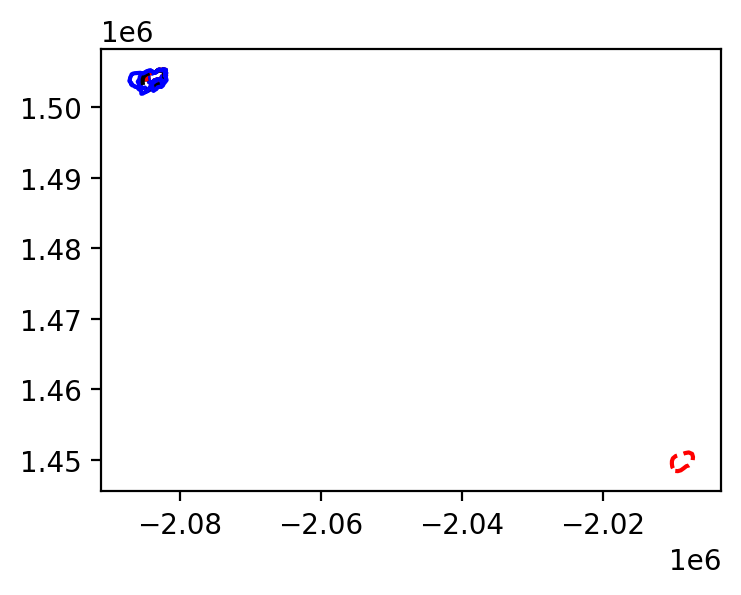

In [27]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
for s in range(len(all_adjusted_states_lst)-3):
    ax.plot(all_adjusted_states_lst[s][::2], all_adjusted_states_lst[s][1::2], color=(0,0,0), ls='--')
    ax.plot(all_simulated_states_lst[s][::2], all_simulated_states_lst[s][1::2], color=(1,0,0), ls='--')
    plot_geometry(maria_observations[s], color=(0,0,1), ls='-', ax=ax)

# plot_geometry(val, ax=ax, color=(1,0,0), lw=1)

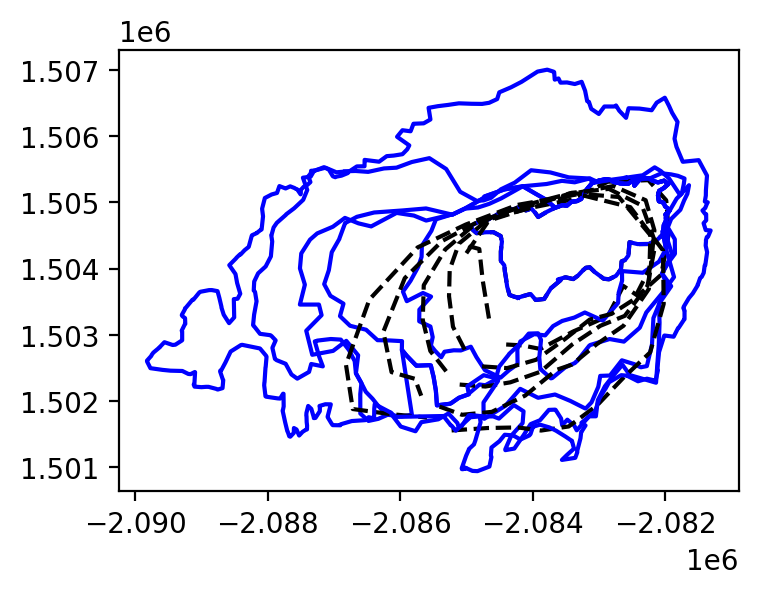

In [21]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
for s in range(len(all_adjusted_states_lst)):
    ax.plot(all_adjusted_states_lst[s][::2], all_adjusted_states_lst[s][1::2], color=(0,0,0), ls='--')
    # ax.plot(all_simulated_states_lst[s][::2], all_simulated_states_lst[s][1::2], color=(1,0,0), ls='--')
    plot_geometry(maria_observations[s], color=(0,0,1), ls='-', ax=ax)

# plot_geometry(val, ax=ax, color=(1,0,0), lw=1)

## Workflow of Maria Fire EnKF

In [ ]:
%%time

# Input of data assimilation
n_vertex = 100
n_states = 2*n_vertex
n_output = n_states

X = 100*np.eye(n_states)  # Initial covariance matrix

# adjusted_simulations
all_adjusted_states_lst = []
all_simulated_states_lst = []

# Prediction for tix=1
# Using the first observation, simulate to the next timepoint
initial_state = geom_to_vector(maria_observations[0])
print('Setting up the first timepoint (ignition)')
all_adjusted_states_lst.append(initial_state)
all_simulated_states_lst.append(initial_state)
# For each sample of the wd and ws, run a simulation and take average as the final

print('Calculating the first prediction tix=1')
zkphat_ensemble = np.zeros((n_states, n_samples))
for s in tqdm(range(n_samples)):
    wd = sampled_wdlst[s]
    ws = sampled_wslst[s]

    forward_geom = forward_pass_farsite(Polygon(zip(initial_state[::2], initial_state[1::2])))
    forward_state = geom_to_vector(forward_geom)
    aligned_states = align_states([initial_state, forward_state], vertex_count = n_vertex)
    
    zkphat_ensemble[:,s:(s+1)] = aligned_states[1]

zkphat_mean = zkphat_ensemble.mean(axis=1, keepdims=True)
all_adjusted_states_lst.append(zkphat_mean)
all_simulated_states_lst.append(zkphat_mean)

print('Starting calculating of data assimilation')
### EnKF adjustments ###
Xlst = [X]

for tix in range(1,len(observations)):
    print(f'Calculating {tix}/{len(observations)}')
    # Using the forward simulation ensemble average as the initial_state for the next timepoint
    # Note that, we are now at tix=1, and predict for tix=2
    initial_state = all_adjusted_states_lst[-1]
    observation_state = xy_to_state(*observations[tix])
    
    adjusted_state, X, zkphat_ensemble, xkhat_ensemble, ykhat_ensemble = adjusted_state_EnKF(initial_state, observation_state, X, n_states, n_samples, rng, sampled_wslst, sampled_wdlst)
    Xlst.append(X)
    all_adjusted_states_lst.append(adjusted_state)

    initial_state = all_simulated_states_lst[-1]
    ## Calculating without any adjustments
    zkphat_ensemble = np.zeros((n_states, n_samples))
    for s in tqdm(range(n_samples)):
        wd = sampled_wdlst[s]
        ws = sampled_wslst[s]
        
        x1, y1 = forward_pass_nsteps(initial_state[::2], initial_state[1::2], [wd]*nsteps, step_size*ws, nsteps)
        forward_state = xy_to_state(x1,y1)
        aligned_states = align_states([initial_state, forward_state])
        
        zkphat_ensemble[:,s:(s+1)] = aligned_states[1]
    all_simulated_states_lst.append(zkphat_ensemble.mean(axis=1, keepdims=True))

In [28]:
initial_geom = maria_observations[0]
compare_geom = maria_observations[1]
dt = maria_timestamps[1] - maria_timestamps[0]

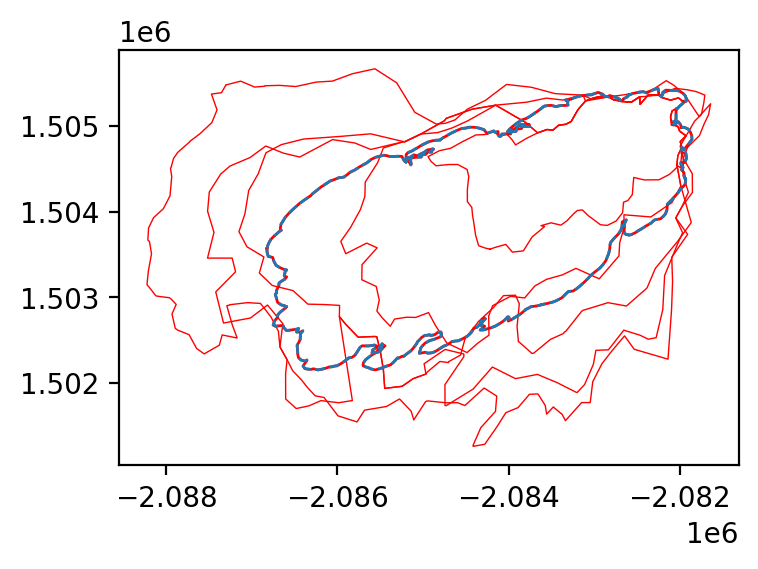

In [122]:
dt = maria_timestamps[4]-maria_timestamps[0]
val = forward_pass_farsite(maria_observations[0], {'windspeed': 30,
                                                   'winddirection': 60,
                                                   'dt': dt}).buffer(0)

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_geometry(val, ax=ax, color=(1,0,0), lw=1)
# plot_geometry(compare_geom, ax=ax, color=(1,0,0), lw=0.5)
for geom in maria_observations[:5]:
    plot_geometry(geom, ax=ax, color=(1,0,0), lw=0.5)
plot_geometry(val, ax=ax, color='tab:blue', lw=1, ls='--')

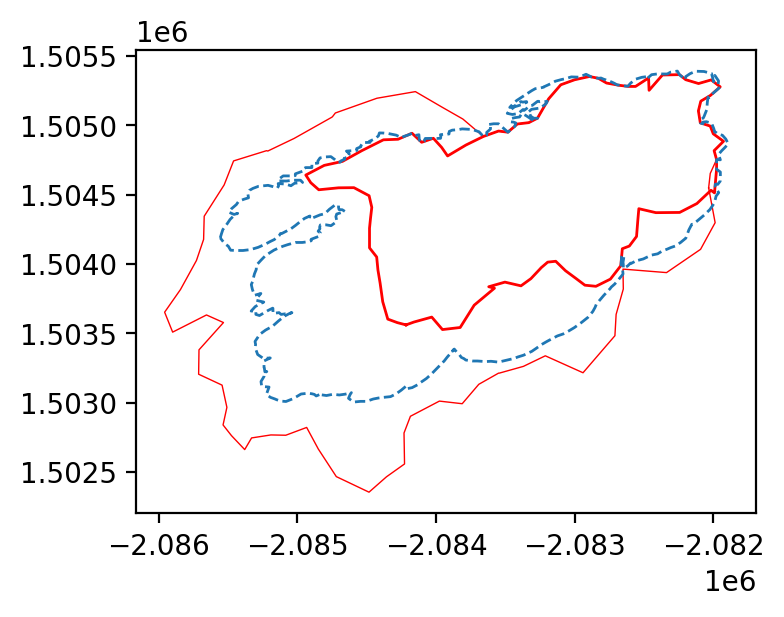

In [26]:
initial_geom_interp = interpolate_geom(initial_geom, 100)


In [ ]:
val = val.buffer(0)
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_geometry(maria_observations[0], ax=ax, color=(1,0,0), lw=1)
plot_geometry(maria_observations[1], ax=ax, color=(1,0,0), lw=0.5)
plot_geometry(val, ax=ax, color='tab:blue', lw=1, ls='--')

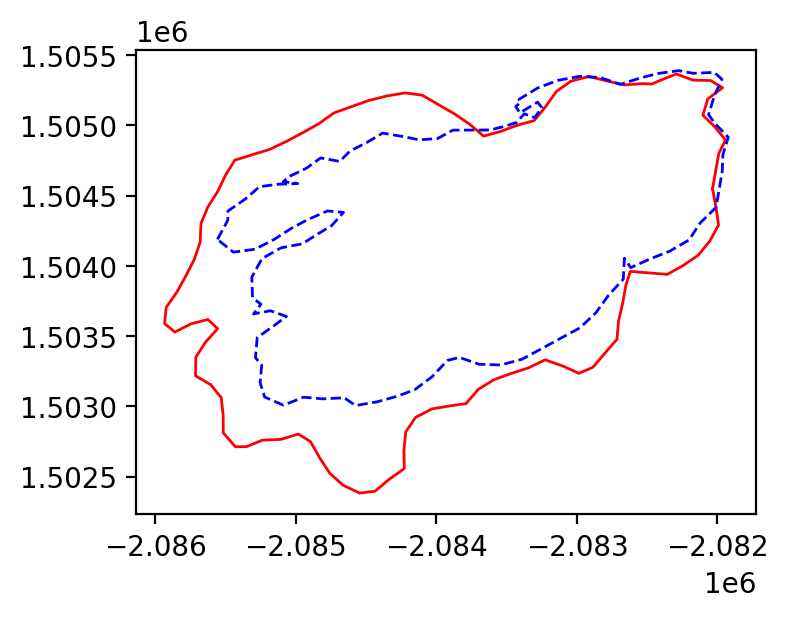

In [34]:
compare_geom_interp = interpolate_geom(compare_geom, 100)
forward_geom_interp = interpolate_geom(val, 100).buffer(0)

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_geometry(compare_geom_interp, ax=ax, color=(1,0,0), lw=1)
plot_geometry(forward_geom_interp, ax=ax, color=(0,0,1), lw=1, ls='--')